In [3]:
using Polynomial

LoadError: Polynomial not found
while loading In[3], in expression starting on line 1

In [4]:
using PyPlot

INFO: Loading help data...


# Introducción

*Preliminares*

La ecuación de Schrödinger en el espacio de configuración es, probablemente, una de las ecuaciones que más información nos pueden dar sobre el mundo microscópico. Como toda ecuación diferencial, sólo se conocen soluciones exactas para los potenciales más sencillos. Cuando queremos considerar sistemas más elaborados hay dos sopas: usar métodos perturbativos y aproximaciones por series de potencias, o usar métodos numéricos. 

Este problema consiste en resolver la ecuación diferencial de segundo orden
$$
\left(-\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x) \right)\psi(x) = E \psi(x)
$$

donde $V(x)$ es el potencial al que está sometida la partícula y $|\psi(x)|^2$ la probabilidad de encontrarla en la posición $x$.

*Método de numerov*

El método de Numerov es un método *marchante* que, a pesar de ser relativamente fácil de implementar, puede arrojar resultados muy cercanos a la realidad.

Para derivarlo, expandimos en serie de Taylor la versión discretizada de $\psi$:
$$\psi(x_{\pm 1})=\psi(x_0) \pm \psi'(x_0) \Delta + \frac{1}{2!}\psi''(x_0)
\Delta^2 \pm \frac{1}{3!}\psi^{(3)}(x_0) \Delta^3 + \frac{1}{4!}\psi^{(4)}(x_0)
\Delta^4 \pm \frac{1}{5!}\psi^{(5)}(x_0) \Delta^5 + \mathcal{O}(\Delta^6)$$

Si sumamos estos compas, tenemos que las potencias impares se nos van:
$$\psi(x_{+ 1})+\psi(x_{- 1}) =2\psi(x_0)  + \psi''(x_0)
\Delta^2 + \frac{1}{12}\psi^{(4)}(x_0)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Si definimos $\delta(g(x))=g(x+\Delta/2) - g(x-\Delta/2)$, tenemos que

$$\delta^2 = \delta(\delta(g))= g(x+\Delta)-g(x) - (g(x) - g(x-\Delta)) $$

Si le aplicamos esta chulada a $\psi$, tenemos que:

$$\delta^2(\psi_n) = \psi_{n+1}  + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\psi^{(4)}(x_n)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Ahora vemos cómo se vería la cuarta derivada como función de la segunda
derivada:

$$\delta^2(\psi''_n) = \psi''_{n+1} + \psi''_{n-1} - 2\psi''_n  = \psi^{(4)}(x_0)
\Delta^2 + \mathcal{O}(\Delta^4)$$ y lo enchufamos en la expresión anterior:

$$\delta^2(\psi_n) = \psi_{n+1} + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\delta^2(\psi''(x_n))
\Delta^2 + \mathcal{O}(\Delta^6)$$

De la ec. de Schrödinger tenemos que $\psi''(x)=f(x)\psi(x)$, con $f(x) = V(x)-E$, que
en lenguaje discreto se ve como $\psi''_n=f_n\psi_n$. Podemos usar esto en la
ecuación anterior para cambiar poner a todas las segundas derivadas en función
de $\psi$:
$$ \psi_{n+1}+\psi_{n-1} - 2\psi_n  = f_{n}\psi_{n}
\Delta^2 + \frac{1}{12}(f_{n+1}\psi_{n+1} + f_{n-1}\psi_{n-1} - 2f_{n}\psi_{n})
\Delta^2 + \mathcal{O}(\Delta^6)$$

Ahora bien, si pasamos los $f_i\psi_i$, del lado izquierdo, se tiene que

$$ \psi_{n+1}\left(1 - \frac{\Delta^2 f_{n+1}}{12}\right) + \psi_{n-1}\left(1 - \frac{\Delta^2 f_{n-1}}{12}\right) - 2\psi_n\left(1 - \frac{\Delta^2 f_{n} }{12}\right)  = f_{n}\psi_{n}
\Delta^2 + \mathcal{O}(\Delta^6)$$ que haciendo $\phi_n = \psi_n(1-\Delta ^2 f_n/12)$ toma la forma

$$ \phi_{n+1} + \phi_{n-1}- 2\phi_n  = f_{n}\psi_{n}
\Delta^2 $$ 

O bien,
$$ \phi_{n+1} =  2\phi_n - \phi_{n-1}  + f_{n}\psi_{n}
\Delta^2 $$ 

De esta fórmula vemos que el método de numerov (como todos los métodos numéricos para segundas derivadas) necesita dos puntos iniciales para empezar a trabajar. Además, recordando la expansión en serie de Taylor, vemos que el error de este método es de orden sexto en $\Delta$.

# Un ejemplo sencillo: pozo infinito

Consideremos la ecuación de Schrödinger con un potencial de la forma 
$$
V(x)
\cases{
0, x \in [0,L]\\
\infty, x \notin [0,L]
}
$$

Aunque computacionalmente no es posible usar valores no acotados, el significado físico del potencial infinito es que ahí la función de onda vale 0, lo cual nos da condiciones de frontera en $x=0$ y $x=L$. De ahora en adelante tomaremos $\hbar = L=1$ y $m=1/2$ para simplificar las ecuaciones. En ese caso, sabemos que nuestras soluciones son de la forma 
$$
\psi_n = \sin(kx); \quad k = n\pi \Rightarrow E=n^2\pi^2
$$

In [5]:
using PyPlot

In [6]:
#Definimos el numerov de izquierda a derecha
function numerov_L(N, E, f, x_i, x_f)
    g(x) = (f(x) - E)
    Delta = (x_f-x_i)/N
    phi = zeros(Float64, N)
    #definimos los primeros dos elementos
    phi[1] = 0
    phi[2] = 0.001(1 - Delta^2 * g(x_i+Delta)/12)
    #hacemos el paso iterativo
    for i in 3:N
        phi[i] = 2*phi[i - 1] - phi[i - 2] + Delta^2 * g((i - 1) * Delta + x_i) * phi[i - 1] / (1 - Delta^2 * g((i - 1) * Delta+ x_i)/12)
    end
    #regresamos el valor de cada ψ_n  en un arreglo
    return float([phi[i]/((1 - Delta^2 * g(i * Delta + x_i)/12)) for i in 1:N])
end
#Y la que va hacia la izquierda
function numerov_R(N, E, f, x_i, x_f)
    g(x) = (f(x) - E)
    Delta = (x_f-x_i)/N
    phi = zeros(Float64, N)
    #definimos los últimos dos elementos
    phi[end] = 0
    phi[end-1] = 0.001*(1 - Delta^2 * g(x_f-Delta)/12)
    #hacemos el paso iterativo
    for i in reverse(1:N - 2)
        phi[i] = 2*phi[i + 1] - phi[i + 2] + Delta^2 * g((i + 1) * Delta+ x_i) * phi[i + 1] / (1 - Delta^2 * g((i + 1) * Delta+ x_i)/12)
    end
    #regresamos el valor de cada ψ_n  en un arreglo
    return float([phi[i]/((1 - Delta^2 * g(i  * Delta+ x_i)/12)) for i in 1:N])
end



numerov_R (generic function with 1 method)

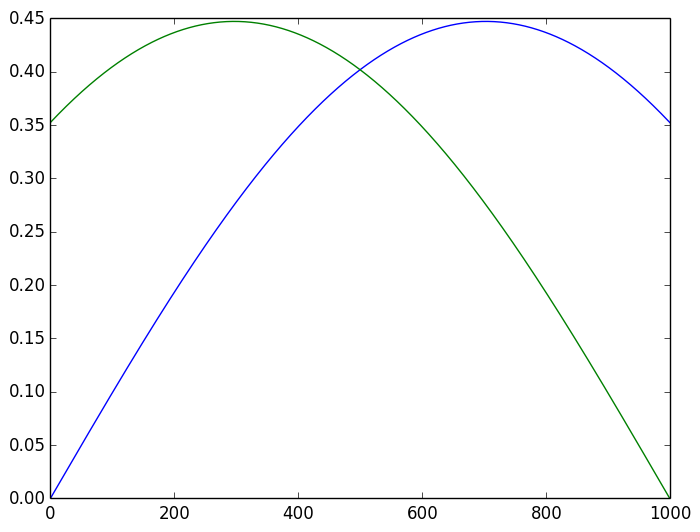

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11423e4c>

In [7]:
#Una pequeña prueba
#using PyPlot
funcion(x) = 0
N = 1000
dx =1/N
E = 5
ψ_L = numerov_L(N, E, funcion, 0,1)
ψ_R = numerov_R(N, E, funcion, 0,1)
plot(ψ_L)
plot(ψ_R)


Para el método de disparo no hace falta usar ambas soluciones, pero es reconfortante ver que arrojan resultados similares. 

Para normalizar necesitamos calcular la integral (discreta) de nuestra función. Esta tendrá la forma $|\psi|^2=\sum\psi_i^2\Delta$:

In [8]:
function normaliza(phi, N, x_i, x_f)
    norma=0
    dx = (x_f-x_i)/N
    for i in 1:N
        norma += (phi[i])^2 * (dx)#Se va acumulando el valor de la integral
    end
    return phi ./ (norma)^(1/2) #Se regresa el arreglo de ψ con cada entrada dividida entre la norma.
end

normaliza (generic function with 1 method)

Para el metodo de disparo, necesitamos una función que se regrese el valor de la solución en el extremo. Así que le hacemos algunas modificaciones a `numerov_L`.

In [9]:
function numerov_3xtr3mo(N, E, f, x_i, x_f)
    g(x) = (f(x) - E)
    Delta = (x_f-x_i)/N
    phi = zeros(Float64, N)
    #definimos los primeros dos elementos
    phi[1] = 0
    phi[2] = 0.001(1 - Delta^2 * g(x_i+Delta)/12)
    #hacemos el paso iterativo
    for i in 3:N
        phi[i] = 2*phi[i - 1] - phi[i - 2] + Delta^2 * g((i - 1) * Delta + x_i) * phi[i - 1] / (1 - Delta^2 * g((i - 1) * Delta+ x_i)/12)
    end
    #hasta ahora,  hizo lo mismo, pero aquí sólo regresa el último valor del arreglo
    i=N
    return phi[i]/((1 - Delta^2 * g((i - 1) * Delta)/12))
end

numerov_3xtr3mo (generic function with 1 method)

Definimos una función que implementa el método de bisección. El método de disparo consiste en encontrar los ceros de `numerov_3xtr3mo`, pues representan las energías $E_i$ para las cuales $\psi(x)$ satisface las condiciones a la frontera.

In [10]:
function bisec(a,b,paso,f)
    if paso == 100
        (a + b)/2
    elseif sign(f(a)) != sign(f((a+b)/2))
        bisec(a,(a + b)/2,paso + 1,f)
    elseif sign(f(b)) != sign(f((a + b)/2))
        bisec((a + b)/2,b,paso + 1,f)
    else
        println("La función no cambia de signo en $a, $b.")
        println("Intenta con otro intervalo.")
    end
end

bisec (generic function with 1 method)

In [42]:
#Juntamos todo en una rutina eficiente y guapa; a y b son los extremos del intervalo donde buscaremos la eigenenergía
function numerov_shooting(N, a, b, f, x_i, x_f)
    E_0 = bisec(a, b, 1, (u->numerov_3xtr3mo(N, u, f, x_i, x_f)))
    normaliza((numerov_L(N, E_0, f, x_i, x_f)), N, x_i, x_f), E_0
end


numerov_shooting (generic function with 1 method)

In [43]:
#Haremos una rutina que genere las soluciones analíticas para el pozo de longitud 1
function pozo_analitico(x,n)
    return sqrt(2)*sin(pi*n*x)
end

pozo_analitico (generic function with 1 method)

In [44]:
N=100
x_i = 0
x_f = 1
funcion(x)=0
ψ , E = numerov_shooting(N, 0, 15, funcion, x_i,x_f)
#Solución analítica
x = linspace(x_i,x_f,N)
ana = map(u-> pozo_analitico(u,1), x)

100-element Array{Float64,1}:
 0.0        
 0.0448701  
 0.089695   
 0.13443    
 0.179029   
 0.223448   
 0.267642   
 0.311566   
 0.355177   
 0.39843    
 0.441282   
 0.48369    
 0.52561    
 ⋮          
 0.48369    
 0.441282   
 0.39843    
 0.355177   
 0.311566   
 0.267642   
 0.223448   
 0.179029   
 0.13443    
 0.089695   
 0.0448701  
 1.73191e-16

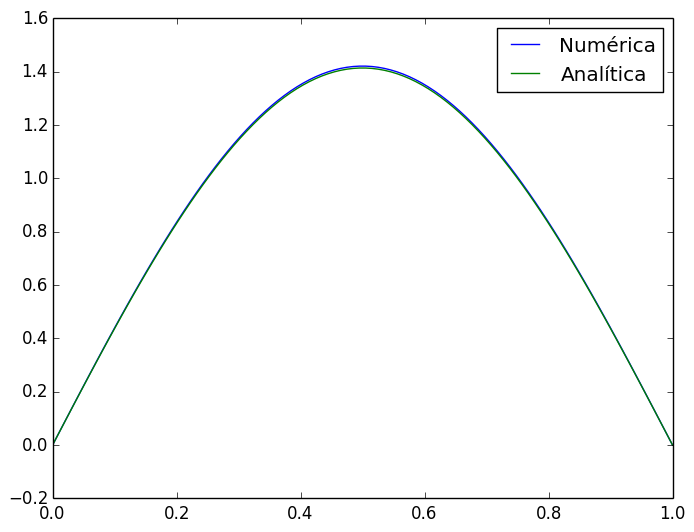

PyObject <matplotlib.legend.Legend object at 0x1310ef4c>

In [45]:
#Graficamos la solución
plot(x, ψ, label = "Numérica")
plot(x, ana, label = "Analítica")
legend()

Las soluciones coinciden bastante bien. Veremos ahora si las energías también coinciden:

In [13]:
pi^2

9.869604401089358

Y vemos que coincide bastante bien con el valor de $10.07$ que obtuvimos con el método de Numerov. Vamos a buscar más arriba a ver si encontramos la dependencia cuadrática:

In [48]:
N=100
funcion(x)=0
ψ , E = numerov_shooting(N, 15, 50, funcion, 0,1)
x = linspace(x_i,x_f,N)
ana = map(u-> pozo_analitico(u,2), x)

100-element Array{Float64,1}:
  0.0        
  0.089695   
  0.179029   
  0.267642   
  0.355177   
  0.441282   
  0.52561    
  0.607822   
  0.687586   
  0.764582   
  0.838498   
  0.909039   
  0.975919   
  ⋮          
 -0.909039   
 -0.838498   
 -0.764582   
 -0.687586   
 -0.607822   
 -0.52561    
 -0.441282   
 -0.355177   
 -0.267642   
 -0.179029   
 -0.089695   
 -3.46382e-16

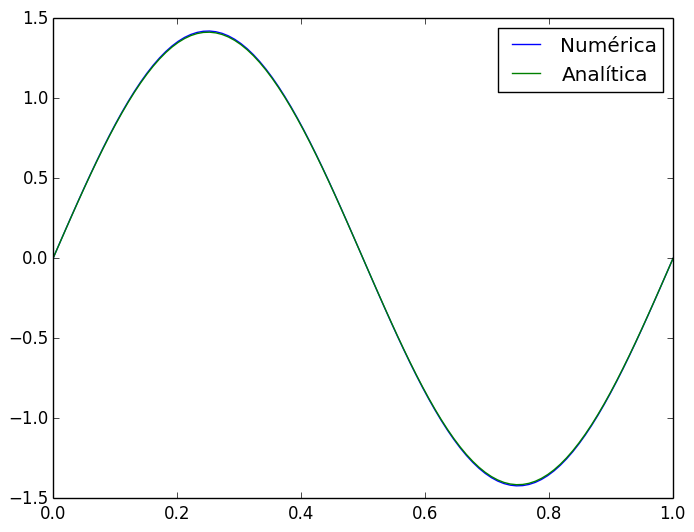

PyObject <matplotlib.legend.Legend object at 0x1323dc6c>

In [49]:
#La energía se parece a  $2^2 π^2$, vamos a ver si la función se comporta como debe:
#Graficamos la solución
plot(x, ψ, label = "Numérica")
plot(x, ana, label = "Analítica")
legend()

In [50]:
#Calcularemos el error porcentual:
(E-4*pi^2)/4*pi^2

1.9777923939954436

Y vemos que lo hace :). Más aún, hay que reconocer que obtuvimos valores de la energía (la cantidad física más relevante de este sistema) con un error de menos del $2\%$, a pesar de usar tan sólo una malla de $100$ puntos, cosa bastante sorprendente.  Encontrar los eigenvalores subsecuentes simplemente requiere seguir probando distintos intervalos.

Ahora vale la pena explorar potenciales más complicados, pues el pozo infinito es el más sencillo (y el menos físico, para ser francos). Por ejemplo, podemos pensar en un pozo infinito con una barrera finita adentro y analizar cómo cambian los estados de este sistema con respecto a los del pozo sencillito. Así,
$$
V(x)=
\begin{cases}
0, &x\notin [0.2,0.4]\\
10, &x\in [0.2,0.4]
\end{cases}
$$

In [51]:
#Armamos la malla
N=100
#Definimos al potencial
function V(x)
    if x<=0.4 && x>=0.2
        return 10
    else
        return 0
    end
end
#Y hacemos la machaca
ψ , E = numerov_shooting(N, 0, 15, V, 0,1)

([0.0,0.0386204,0.0771928,0.115669,0.154003,0.192145,0.230048,0.267667,0.304953,0.341861  …  0.455315,0.406159,0.356498,0.306395,0.255912,0.205112,0.154057,0.102811,0.0514374,-1.49689e-15],12.408289890038702)

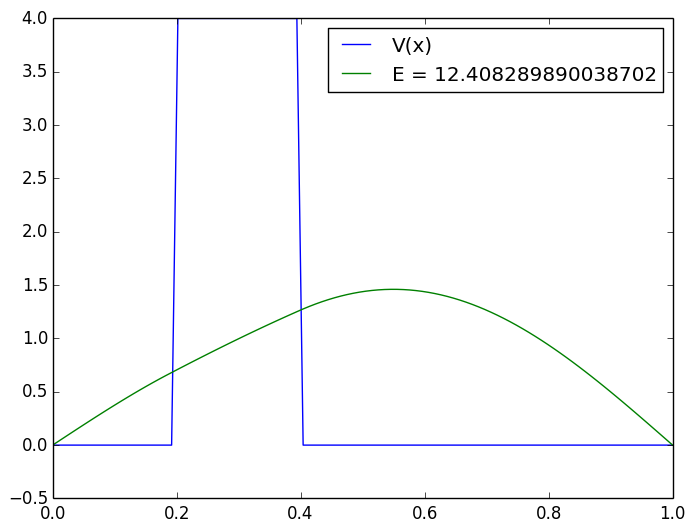

PyObject <matplotlib.legend.Legend object at 0x1334174c>

In [53]:
#Vamos a graficarla junto con el potencial para analizar el comportamiento
x = linspace(0,1,N)
V_x = map(V, x)
plot (x, 0.4V_x, label = "V(x)")
plot (x, ψ, label = "E = $E")
legend(loc=1)

Y vemos que el método funciona bien y nota el cambio en la energía del estado base. Podemos analizar un potencial con un vado en lugar de una barrera:
$$
V(x)=
\begin{cases}
0, &x\notin [0.2,0.4]\\
-10, &x\in [0.2,0.4]
\end{cases}
$$

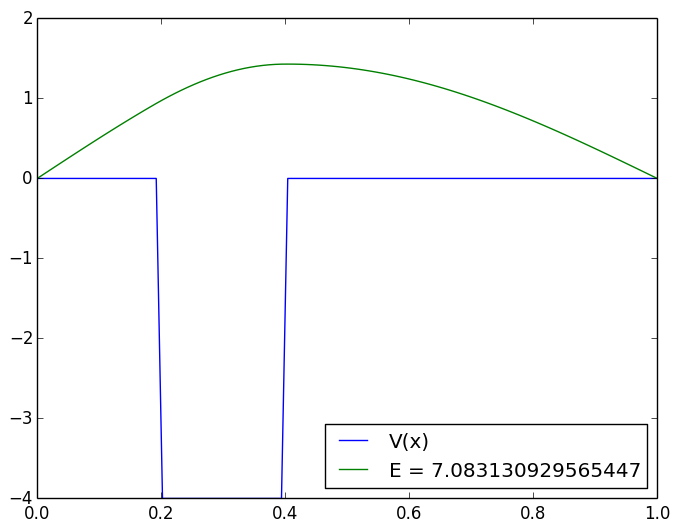

PyObject <matplotlib.legend.Legend object at 0x1356b72c>

In [54]:
#Armamos la malla
N=100
#Definimos al potencial
function V2(x)
    if x<=0.4 && x>=0.2
        return -10
    else
        return 0
    end
end
#Y hacemos la machaca
ψ , E = numerov_shooting(N, 0, 15, V2, 0,1)
#Vamos a graficarla junto con el potencial para analizar el comportamiento
x = linspace(0,1,N)
V_x = map(V2, x)
plot (x, 0.4V_x, label = "V(x)")
plot (x, ψ, label = "E = $E")
legend(loc="lower right")

Esta vez la energía del estado base es menor y el pico de mayor probabilidad se cargó hacia el vado. 

Ahora sigue intentar atacar potenciales que no tengan barreras perfectas. Y el primer pasito es el oscilador armónico:
$$
V(x) = \frac{1}{2} m \omega^2 x^2
$$
que con $\omega = 2$ y $m = 1/2$ toma la forma

$$
V_o(x) = x^2
$$

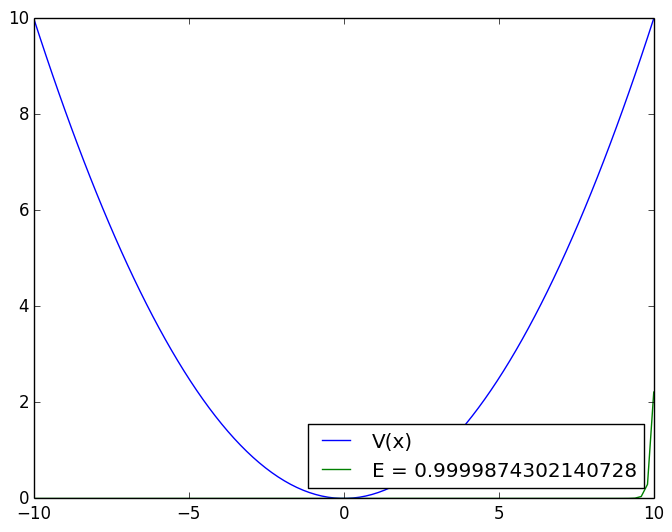

PyObject <matplotlib.legend.Legend object at 0x13a53aac>

In [55]:
#Hacemos lo mismo con este potencial nuevo
N=100
V_o(x) = (x)^2
x_i = -10
x_f = 10
ψ , E = numerov_shooting(N, 0, 5, V_o, x_i,x_f)
#Vamos a graficarla junto con el potencial para analizar el comportamiento
x = linspace(x_i,x_f,N)
V_x = map(V_o, x)
plot (x, 0.1.*V_x, label = "V(x)")
plot (x, ψ, label = "E = $E")
legend(loc="lower right")


Y vemos que la solución que se construye arrancando desde la izquierda, truena horrible hacia la derecha. Es evidente que la de la derecha hará algo análogo. Este tipo de problemas deben ser atacados con el *método de igualación*, que será expuesto en la próxima sección.


# Método de igualación

No siempre conocemos las condiciones iniciales de $\psi$ y
$d\psi/dx$. Por lo que las consideraciones de simetría que se utilizan
para conocer las condiciones iniciales que se necesitan para el método
del disparo no son válidas.

Lo único que nos queda es la continuidad de $\psi$ y de la derivada.

Se consideran dos funciones de onda, una que se resuelve de izquierda
a derecha y la otra de derecha a izquierda. Se supone que la función
de onda inicia en cero y la derivada es pequeña. Estas dos soluciones
se intersectan en un punto. El objetivo es hacer que la concatenación
de estas dos soluciones sea continua.

Primero empatamos las funciones utilizando constantes $a$ y $b$ tal
que, $a\psi$ y $b\psi$ coincidan en un punto encima del mínimo del
potencial. Para empatar las derivadas, usamos la adivinanza de la
energía.

Para potenciales no simétricos hay que hacer una rutina que empata a
$\psi_l$ y a $\psi_r$ cerca del mínimo del potencia.

Aquí también se usaron las consideraciones para $\hbar$ y $\omega$, por lo que las energías son
$$
E_n = 2(n+1/2).
$$

In [1]:
function empata_func(N, E, V, x_i, x_f, x_min)
    #Encontramos el punto de la malla correspondiente al mínimo:
    Delta = (x_f-x_i)/N
    i_min = int((x_min-x_i)/Delta)
    #Construimos las soluciones izquierdas y derechas:
    ψ_L = numerov_L(N, E, V, x_i, x_f)
    ψ_R = numerov_R(N, E, V, x_i, x_f)
    #Para que las funciones coincidan, multiplicamos una de ellas por el factor necesario
    ψ_L = ψ_L .* (ψ_R[i_min]/ψ_L[i_min])
   
    return ((ψ_R[i_min+1] - ψ_R[i_min-1]) -( ψ_L[i_min+1] - ψ_L[i_min-1]))/(2Delta*ψ_R[i_min])
    
end

empata_func (generic function with 1 method)

# Oscilador armónico

La solución analítica para el oscilador armónico es
$$
\frac{1}{\sqrt{2^nn!}}\left(\frac{m\omega}{\pi\hbar}\right)^{1/4}
e^{-\frac{m\omega x^2}{2\hbar}}
H_n\left(\sqrt{\frac{m\omega}{\hbar}}x\right).
$$
con eigenvalores son $\hbar\omega(1/2+n)$, con $n \in\mathbb{N}$ y $H_n$ son los polinomios de Hermite.

In [21]:
function prhermite_coefmatrix(n::Int, T)
    m = zeros(T, n, n)
    
    if n == 0
        return m
    end
    
    m[1, 1] = one(T)
    
    if n == 1
        return m
    end
    
    m[2, 2] = one(T)
      
    for l in 3:n
        m[1, l] = - (l - 2) * m[1, l-2]
        for i in 2:n
            m[i, l] = m[i-1, l-1] - (l - 2) * m[i, l-2]
        end
    end

    m
end

function phhermite_coefmatrix(n::Int, T)
    m = zeros(T, n, n)
    
    if n == 0
        return m
    end
    
    m[1, 1] = one(T)
    
    if n == 1
        return m
    end
    
    m[2, 2] = 2 * one(T)
      
    for l in 3:n
        m[1, l] = - 2 * (l - 2) * m[1, l-2]
        for i in 2:n
            m[l, i] = 2 * (m[i-1, l-1] - (l - 2) * m[i, l-2])
        end
    end

    m
end
function fuconda(n,pol,x)
    (1/sqrt(2^n*factorial(n)))*e^(-x^2/2)*(1/pi)^(1/4)*polyval(pol,x)
end
her(n) = Poly(reverse(prhermite_coefmatrix(n, Float64)[:,n]))

her (generic function with 1 method)

La función `prhermite_coefmatrix` nos permite encontrar los
coeficientes de los __polinomios de hermite__ que son
calculados con la función `her`. La función `fuconda`
devuelve la solución analítica para el oscilador armónico.

# Eigenenergías

Se utiliza la función `empata_func` para encontrar el valor de la __energía__ que nos iguala la derivada en el punto en donde las curvas se __intersectan__.

In [56]:
N=100
x_i = -10
x_f = 10

energias = linspace(0,10,100)
F = map((x -> empata_func(N, x, V_o, x_i, x_f, 0)), energias)
plot(energias, F)
title("Eigenenergías")
ylim(-1,1)

LoadError: empata_func not defined
while loading In[56], in expression starting on line 6

La función `numerov_empata` empaqueta la función que reliza Numerov de derecha a izquierda y de izquierda a derecha. Encuentra---a partir de dos energías---el valor de eigenenergía y calcula la solución. Finalmente la normaliza.

In [23]:
function numerov_empata(N, E_1, E_2, V, x_i, x_f, x_min)
    #Encontramos la eigen-energía
    E_0 = bisec(E_1, E_2, 1, (u->empata_func(N, u, V, x_i, x_f, x_min)))
    #Construimos las soluciones izquierdas y derechas:
    ψ_L = numerov_L(N, E_0, V, x_i, x_f)
    ψ_R = numerov_R(N, E_0, V, x_i, x_f)
    #Encontramos el punto de la malla correspondiente al mínimo:
    Delta = (x_f-x_i)/N
    i_min = int((x_min-x_i)/Delta)
    #Para que las funciones coincidan, multiplicamos una de ellas por el factor necesario
    ψ_L = ψ_L .* (ψ_R[i_min]/ψ_L[i_min])
    #Armamos la solución con los cachitos correspondientes
    ψ = zeros(ψ_L)
    for i in 1:i_min
        ψ[i] = ψ_L[i]
    end
    for i in i_min:N
        ψ[i] = ψ_R[i]
    end
    normaliza(ψ, N, x_i, x_f), E_0

end

numerov_empata (generic function with 1 method)

# Eigenfunciones oscilador armónico

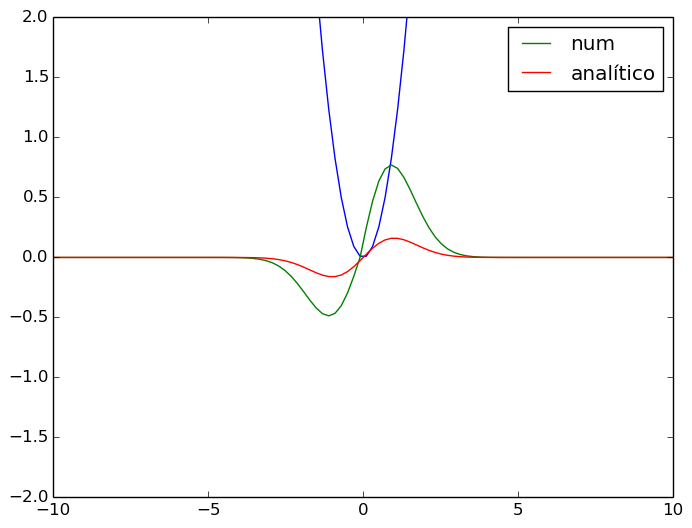

PyObject <matplotlib.legend.Legend object at 0x7ff689c119d0>

In [24]:
N=100
x_i = -10
x_f = 10
ψ, E_0 = numerov_empata(N, 2, 4, V_o, x_i, x_f, 0)
x = linspace(x_i,x_f,N)
malla_o = map(V_o, x)
plot(x, malla_o)
plot(x, ψ,label="num")
ylim(-2, 2)
## analítico
x = linspace(-10,10)
y = [fuconda(2,her(2),u) for u in x]
plot(x,y,label="analítico")
legend()

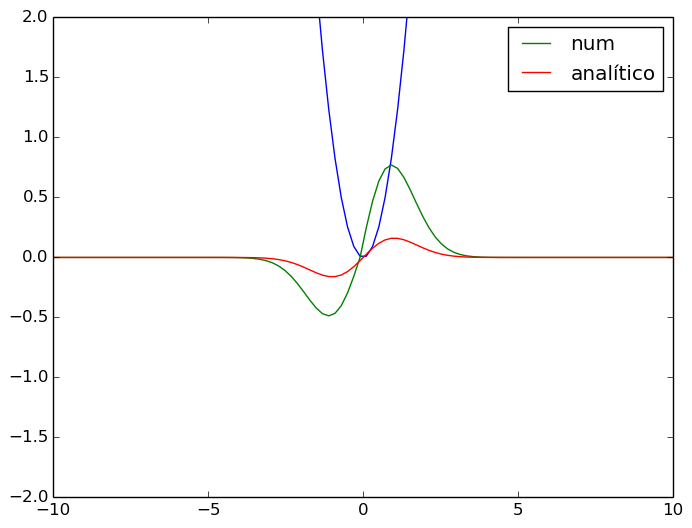

PyObject <matplotlib.legend.Legend object at 0x7ff689dd9c50>

In [25]:
x = linspace(x_i,x_f,N)
malla_o = map(V_o, x)
plot(x, malla_o)
plot(x, ψ,label="num")
ylim(-2, 2)
## analítico
x = linspace(-10,10)
y = [fuconda(2,her(2),u) for u in x]
plot(x,y,label="analítico")
legend()

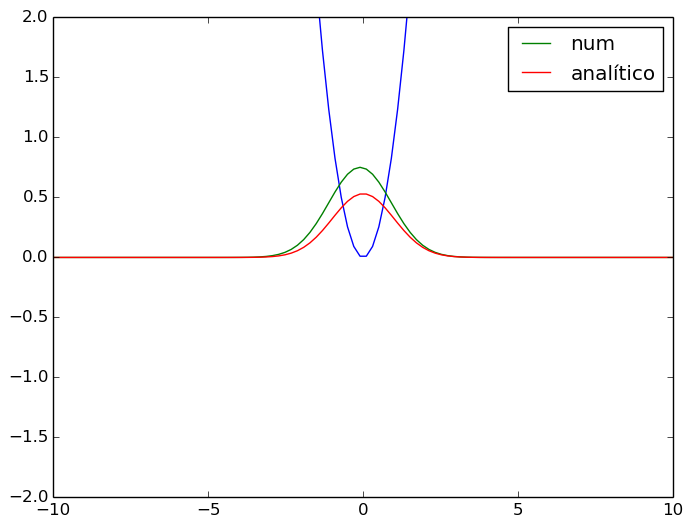

PyObject <matplotlib.legend.Legend object at 0x7ff689a3c610>

In [28]:
N=100
x_i = -10
x_f = 10
ψ, E_0 = numerov_empata(N, 0, 2, V_o, x_i, x_f, 0)
x = linspace(x_i,x_f,N)
malla_o = map(V_o, x)
plot(x, malla_o)
plot(x, ψ,label="num")
ylim(-2, 2)
## analítico
x = linspace(-10,10)
y = [fuconda(1,her(1),u) for u in x]
plot(x,y,label="analítico")
legend()

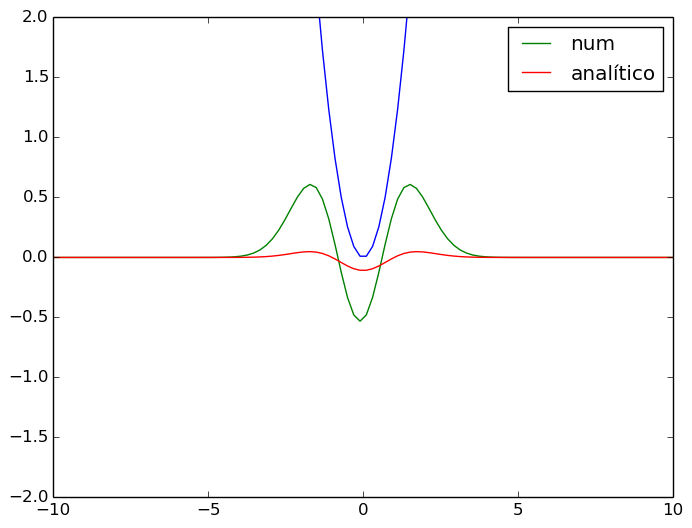

PyObject <matplotlib.legend.Legend object at 0x7ff689bd92d0>

In [29]:
N=100
x_i = -10
x_f = 10
ψ, E_0 = numerov_empata(N, 4, 6, V_o, x_i, x_f, 0)
x = linspace(x_i,x_f,N)
malla_o = map(V_o, x)
plot(x, malla_o)
plot(x, ψ,label="num")
ylim(-2, 2)
## analítico
x = linspace(-10,10)
y = [fuconda(3,her(3),u) for u in x]
plot(x,y,label="analítico")
legend()

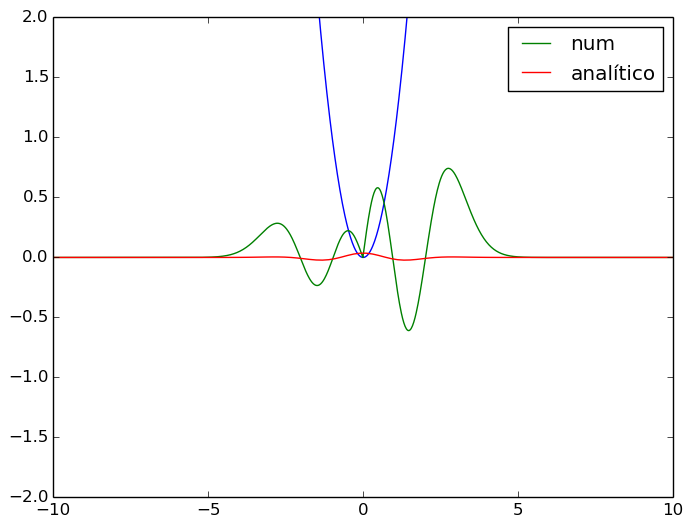

PyObject <matplotlib.legend.Legend object at 0x7ff689aebfd0>

In [30]:
N=1000
x_i = -10
x_f = 10
ψ, E_0 = numerov_empata(N, 9, 11, V_o, x_i, x_f, 0)
x = linspace(x_i,x_f,N)
malla_o = map(V_o, x)
plot(x, malla_o)
plot(x, ψ,label="num")
ylim(-2, 2)
## analítico
x = linspace(-10,10)
y = [fuconda(5,her(5),u) for u in x]
plot(x,y,label="analítico")
legend()